# Lab 2 : Dan Freeman, Ireti Fasere, Tim McWilliams, Peter Kouvaris

## 0. Data Import + Source Overview

Our team used UCI's Adult Census Data : https://archive.ics.uci.edu/ml/datasets/adult

While this notebook is independent regarding the review of assumptions necessary when building classifiers, more extensive review of this data set can be found here: https://github.com/htpeter/pdti_DataMining/blob/master/Lab_1/Lab%201%20Notebook.ipynb


## Notes about our workstyle:
#### - Imports happen near where they are used.
#### - Markdown for general plan and comments on code choices.
#### - Keep master variables in memory for easy access.

In [179]:
# Imports for data-preprocessing
import pandas as pd
import numpy as np
from __future__ import print_function

%matplotlib inline

#for a clean notebook
import warnings
warnings.filterwarnings('ignore')

In [180]:
##### Import data
df = pd.read_csv('../data/master.csv')

In [4]:
df.head(1)

,Unnamed: 0,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_binary,condensed_education,continent,condensed_marital,condensed_workclass
0,0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Bachelors,United States,Never,Government


# Data Preparation

### Variable Pre-processing

We transformed the data set from what it initially was by condensing variables that had infrequent and distributed classes into more concise buckets. This included condensing education, country, marital status, and workclass. This process is verbose to show, so the code is included here:

https://github.com/htpeter/pdti_DataMining/blob/master/data/Train_Test_Script.ipynb

When preparing our X variables for training, we used one-hot encoding via the Pandas' get_dummies function. We also used SciKit's StandardScaler function which scales the values to unit variance and sets the mean to zero.

As shown in the code blocks below, we removed variables that are redundant with the condensed variables added in the notebook above. We also removed a column named "Unnamed: 0" which is an empty vector.

### Income Binary Pre-Processing

Our first classification task will be on *income_binary*, a binary class variable comprised of "<=50K" and ">50K" classes.

In [181]:
# Import for spliting the data set
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# delete unwanted variables from x and setup to be used in classifier
y_income = df['income_binary']

ib_drop = ['income_binary','workclass','education','education_num',
             'marital_status','occupation','native_country','Unnamed: 0']
x_income = df.drop(ib_drop,1)
x_income = pd.get_dummies(x_income).values
x_income = StandardScaler().fit_transform(x_income)

### Age Groups Pre-Processing

Our second classification task is to predict *age_group*, which is a categorical variable created from age. These categories include 17-34, 35-49, 50-64 and 65+.

In [182]:
#bin ranges
bins = [17, 34, 49, 64, 90]

#bin names
group_names = ['17-34', '35-49', '50-64', '65+']

#pandas function to create the bins
age_groups = pd.cut(df.age, bins, labels=group_names)

#make sure to call .tolist(), pd.cut() has very annoying hidden OOP 
#types forced upon the data which will cause errors with sklearn
df['age_groups'] = age_groups.tolist()

In [183]:
# delete unwanted variables from x and setup to be used in classifier
y_ages = df['age_groups']
# pd.cut causes hidden NA types over valid data
y_ages = y_ages.fillna("")

ag_drop = ['age_groups','workclass','education','education_num',
             'marital_status','occupation','native_country','Unnamed: 0','age']

x_ages = df.drop(ag_drop,1)
x_ages = pd.get_dummies(x_ages).values
x_ages = StandardScaler().fit_transform(x_ages)


# Evaluation Metric Selection

Our team has used the SciKit classification_report function in most cases to return an array of evaluation metrics. This returns recall, precision and F1. We hypothesized that accuracy would be the most important for us. This is due to the nature of our prediction, which is guessing the age group and income level of an individual based on census data. The cost associated with incorrect prediction is low, so we can afford to build a model that focuses on accuracy. When we have a model that has the highest out of sample accuracy, it is theoretically leveraging hidden patterns within the data for the period trained.

Our prediction algorthims, which attempt to predict the age group of an individual or whether an individual's income is greater or less than $50,000, are primarly applicable to macroeconomic policy. While the abstract models are often well-defined by economists, data collection is expensive. Even more so, piecing together missing chunks is best done by extending pre-existing knowledge to fill in the gaps. Prediction models like these have the primary goal of expanding a data set outwards so that it represents the reality. Accuracy is the most relevant here, with incorrect guesses being a relatively insignificant cost.


In [184]:
#this is how we will be calculating throughout the notbook:
from sklearn.metrics import classification_report, accuracy_score
#much cleaner to call print so the \n get rendered properly
print(classification_report(['yes','yes','no'],['yes','no','no']))
print('Accuracy : \n')
print(accuracy_score(['yes','yes','no'],['yes','no','no']))

             precision    recall  f1-score   support

         no       0.50      1.00      0.67         1
        yes       1.00      0.50      0.67         2

avg / total       0.83      0.67      0.67         3

Accuracy : 

0.666666666667


# Training and Testing Split - StratifiedKFold + Standardization

The goal of performing cross-validation is to split your data into a training set and test set. The training set is split up into multiple validation sets. We are going to use stratified K-fold cross-validation with 10 splits (K=10) for our classification tasks. This is because our data is unbalanced. There is a total of 48,842 individuals that were surveyed in our data set. Out of all the individuals surveyed, 41,762 are white, 32,650 are male, 37,155 have an income greater than or equal to 50K USD, 43,832 are from the United States, and 33,906 work in the private industry. Stratified K-fold cross-validation ensures that each of our training sets contains an equal proportion of each unbalanced variable. 



In [185]:
from sklearn.model_selection import StratifiedShuffleSplit
# Split the data into 20% Test and 80% Train
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=111)

# Create a for loop that grabs the values for each fold for traing and test sets
for train_index, test_index in sss.split(x_income, y_income):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x_income[train_index], x_income[test_index]
    y_train, y_test = y_income[train_index], y_income[test_index]

TRAIN: [15163 16279 29246 ..., 21159 41049 17832] TEST: [43578  1917 17027 ..., 22163 39121  5217]
TRAIN: [12894 40784 33210 ..., 40386 25846 36294] TEST: [22078 13800    49 ..., 31283 31586  5940]
TRAIN: [16738 39693 30388 ...,   328 33912 39362] TEST: [24310 48705 25069 ..., 47258 14625 39292]
TRAIN: [ 7391 39777 43398 ...,  8978 24399 34458] TEST: [ 8836  1328 27156 ..., 47164 10476 15648]
TRAIN: [16863 33361 41054 ..., 26744 47828 11941] TEST: [18495 35842 20752 ..., 46535  4696 46808]
TRAIN: [ 5743 21257 30549 ...,  5927  7506 19162] TEST: [21737 30911  7484 ..., 19717 27662 19780]
TRAIN: [18797 40559 21393 ..., 47376 19268 42562] TEST: [13861 34766  4320 ..., 42723 30153 11994]
TRAIN: [36977 11147 24500 ..., 40130 15262 22626] TEST: [13974 35810 43678 ...,  7735 14376 40480]
TRAIN: [32752 37107 19197 ..., 26015 32870  7076] TEST: [36370 13966 29812 ..., 20543 23045 34324]
TRAIN: [22441 41471 48039 ..., 32784  4446 45905] TEST: [  934  1627 37667 ...,  4950 44845 21169]


In [49]:
# Create a for loop that grabs the values for each fold for traing and test sets

for train_index, test_index in sss.split(x_ages, y_ages):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x_ages[train_index], x_ages[test_index]
    y_train, y_test = y_ages[train_index], y_ages[test_index]

TRAIN: [ 8492   773 13118 ..., 35980 33511 35588] TEST: [19692 27047 14102 ...,  5491 27134 25133]
TRAIN: [35754 44603 33516 ...,  9966 39949 27930] TEST: [ 6576 30339 39221 ..., 26307 20282 14216]
TRAIN: [ 9692 36813  2848 ..., 16610 48026 24110] TEST: [17088 44904 33742 ..., 39410 34564 24713]
TRAIN: [18717 17405 28960 ..., 17899 20181 28803] TEST: [29770  5237 39991 ..., 19858 25079 39382]
TRAIN: [31784 43606 33743 ..., 43070 11410 40058] TEST: [ 5991  5420 37845 ..., 23131 38821 38455]
TRAIN: [10324 22662 46232 ..., 13002  5850 47428] TEST: [35217 41009 45992 ..., 19937 37685 43961]
TRAIN: [10245 34540 19934 ...,  4642 48455  1175] TEST: [46966 10993 27579 ..., 31110 48759 43327]
TRAIN: [39885  4332  3592 ..., 44157 11660 46607] TEST: [31259 23034  5609 ..., 20253 24091 12492]
TRAIN: [17705 32836 34332 ..., 30752 31903 12175] TEST: [24823 12082 42233 ..., 14850 38281 46484]
TRAIN: [ 9054 18693 13929 ...,  8118 28501 10876] TEST: [37717 40166 28516 ...,  4861 47589  9591]


In [31]:
#for support lets print the instances of classes that are low
for col in df.columns:
    if df[col].dtype == 'O':
        val = df[col].value_counts()
        for i in val:
            if i < 100:
                print(i, col)

21 workclass
10 workclass
83 education
37 marital_status
15 occupation
92 native_country
88 native_country
87 native_country
86 native_country
85 native_country
75 native_country
67 native_country
65 native_country
59 native_country
49 native_country
49 native_country
46 native_country
45 native_country
38 native_country
37 native_country
30 native_country
30 native_country
28 native_country
27 native_country
23 native_country
23 native_country
23 native_country
21 native_country
20 native_country
19 native_country
1 native_country


# Models & Results

For both our sets, the training matrices are one-hot encoded and standardized. We will be predicting two classes in *Income Binary* and four classes in *Age Groups*.

## Income Binary

### Models

1. KNN
2. Random Forest
3. Naive Bayes

## Age Groups

### Models

1. Random Forest
2. Logistic Regression
3. Adaboost



### KNN - Income Binary

In [81]:
from sklearn.neighbors import KNeighborsClassifier
# Classification with KNN on income_binary

# Create reusable KNN object 
KNN = KNeighborsClassifier(n_neighbors=25)

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_income,y_income): 
    X_train = x_income[train_indices]  # train indices for X
    y_train = y_income[train_indices]  # train indices for y
    
    X_test = x_income[test_indices]    # test indices for X
    y_test = y_income[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    KNN.fit(X_train,y_train)  # train object
    y_hat = KNN.predict(X_test) # get test set predictions
    
    if iter_num%4 == 0:
        # Accuracy for the iterations of training/testing
        accuracy_KNN = accuracy_score(y_test,y_hat)  # obtain accuracies for each iteration 
        print("----Iteration",iter_num," ----")         # print out each numbered interation 
        print('KNN accuracy =', accuracy_KNN)            

        #Metric report 
        metrics_KNN = classification_report(y_test,y_hat)  # obtain metric's report for each iteration 
        print('KNN metric report')
        print(metrics_KNN)
        iter_num+=1  # run through the first iteration, then second, then third ... then tenth

----Iteration 0  ----
KNN accuracy = 0.834988228068
KNN metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.93      0.90      7431
       >50K       0.70      0.54      0.61      2338

avg / total       0.83      0.83      0.83      9769



In [91]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
# Lets train a PipeLine with PCA to see if we can increase the accuracy 

# First we need to set up the PipeLine that will take the PCA and then fit a KNN classifier
KNN_pipe = Pipeline([('PCA',PCA(n_components=2,svd_solver='randomized')),
     ('KNN',KNeighborsClassifier(n_neighbors=25))])

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_income,y_income): 
    X_train = x_income[train_indices]  # train indices for X
    y_train = y_income[train_indices]  # train indices for y
    
    X_test = x_income[test_indices]    # test indices for X
    y_test = y_income[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    KNN.fit(X_train,y_train)  # train object
    y_hat = KNN.predict(X_test) # get test set precitions
    
    if iter_num%4 == 0:
        # Accuracy for the iterations of training/testing
        accuracy_KNN = accuracy_score(y_test,y_hat)  # obtain accuracies for each iteration 
        print("----Iteration",iter_num," ----")         # print out each numbered interation 
        print('KNN accuracy =', accuracy_KNN)            

        #Metric report 
        metrics_KNN = classification_report(y_test,y_hat)  # obtain metric's report for each iteration 
        print('KNN metric report')
        print(metrics_KNN)
        iter_num+=1  # run through the first iteration, then second, then third ... then tenth

----Iteration 0  ----
KNN accuracy = 0.834988228068
KNN metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.93      0.90      7431
       >50K       0.70      0.54      0.61      2338

avg / total       0.83      0.83      0.83      9769



In [ ]:
# Accuracies for comparision for each KNN model 

# KNN model 1
print("1. The mean accuracy for KNN model is ", mean_KNN)
print('------------------------------------------------------------------------')

# RF model 2
print("2. The mean accuracy for KNN with PCA model is ", mean_KNN_pipe)
print('------------------------------------------------------------------------')

The mean accuracy for the K-Nearest Neighbor model without the PCA is 83.55%. This is the model we are going to choose for this classifier. Next, we will run a Random Forest classifier and then compare the two classifiers together to see which one generates the highest accuracy for our data.

### Random Forest - Income Binary

The random forest performs incredibly well here.

In [82]:
#Random Forest of Income
from sklearn.ensemble import RandomForestClassifier

# criterion : 'gini' > 'entropy'
# max_features : 0 -> 41 (default is fine)
# bootstrap : keep True
# max_depth : not material

RFC = RandomForestClassifier(random_state=111)

iteration = 1
scores = []
for train_indices, test_indices in sss.split(x_income,y_income): 
    X_train = x_income[train_indices]  # train indices for X          
    y_train = y_income[train_indices]  # train indices for y         
    
    X_test = x_income[test_indices]    # test indices for X
    y_test = y_income[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RFC.fit(X_train,y_train)  # train object
    y_hat = RFC.predict(X_test) # get test set precitions
    
    scores.append(accuracy_score(y_hat,y_test))
    #lets print the 4th and the 8th iter to keep things viewable
    if len(scores)%4 == 0:
        print(classification_report(y_hat,y_test))
    

print("Mean Accuracy : ", np.mean(scores))

             precision    recall  f1-score   support

      <=50K       0.92      0.88      0.90      7750
       >50K       0.60      0.69      0.64      2019

avg / total       0.85      0.84      0.84      9769

             precision    recall  f1-score   support

      <=50K       0.92      0.88      0.90      7757
       >50K       0.59      0.69      0.64      2012

avg / total       0.85      0.84      0.84      9769

Mean Accuracy :  0.839113522367


In [83]:
#Random Forest of Income
from sklearn.ensemble import RandomForestClassifier

# criterion : 'gini' > 'entropy'
# max_features : 0 -> 41 (default is fine)
# bootstrap : keep True
# max_depth : not material

RFC = RandomForestClassifier(max_depth=20,random_state=111)

iteration = 1
scores = []
for train_indices, test_indices in sss.split(x_income,y_income): 
    X_train = x_income[train_indices]  # train indices for X          
    y_train = y_income[train_indices]  # train indices for y         
    
    X_test = x_income[test_indices]    # test indices for X
    y_test = y_income[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RFC.fit(X_train,y_train)  # train object
    y_hat = RFC.predict(X_test) # get test set precitions
    
    scores.append(accuracy_score(y_hat,y_test))
    #lets print the 4th and the 8th iter to keep things viewable
    if len(scores)%4 == 0:
        print(classification_report(y_hat,y_test))
    

print("Mean Accuracy : ", np.mean(scores))

             precision    recall  f1-score   support

      <=50K       0.93      0.88      0.90      7861
       >50K       0.60      0.73      0.66      1908

avg / total       0.87      0.85      0.86      9769

             precision    recall  f1-score   support

      <=50K       0.94      0.88      0.91      7925
       >50K       0.59      0.75      0.66      1844

avg / total       0.87      0.85      0.86      9769

Mean Accuracy :  0.85467294503


In [95]:
# Create an object that holds the third RF model with parameter adjustments

iteration = 1
for max_depth_n in [10,15,25,50,100,150,200]:
    RFC = RandomForestClassifier(max_depth=max_depth_n, random_state=111)
    scores = []
    for train_indices, test_indices in sss.split(x_income,y_income): 
        X_train = x_income[train_indices]  # train indices for X          
        y_train = y_income[train_indices]  # train indices for y         

        X_test = x_income[test_indices]    # test indices for X
        y_test = y_income[test_indices]    # test indices for y

        # train the reusable KNN classifier on the training data
        RFC.fit(X_train,y_train)  # train object
        y_hat = RFC.predict(X_test) # get test set precitions

        scores.append(accuracy_score(y_hat,y_test))

    iteration += 1  
            
            # Accuracies for comparision for each RF model 
    
    # RF model 1
    print("The mean accuracy for RF max_depth = %s is %s" % (str(max_depth_n), np.mean(scores)))
    print('------------------------------------------------------------------------')


The mean accuracy for RF max_depth = 10 is 0.854744600266
------------------------------------------------------------------------
The mean accuracy for RF max_depth = 15 is 0.85768246494
------------------------------------------------------------------------
The mean accuracy for RF max_depth = 25 is 0.846023134405
------------------------------------------------------------------------
The mean accuracy for RF max_depth = 50 is 0.839205650527
------------------------------------------------------------------------
The mean accuracy for RF max_depth = 100 is 0.839113522367
------------------------------------------------------------------------
The mean accuracy for RF max_depth = 150 is 0.839113522367
------------------------------------------------------------------------
The mean accuracy for RF max_depth = 200 is 0.839113522367
------------------------------------------------------------------------


In [100]:
# Create an object that holds the second RF model with parameter adjustments

RF2= RandomForestClassifier(max_depth=10, random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the RF above
# Now we want to iterate through and grab the prediction, just like we did in the KNN above
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_income,y_income): 
    X_train = x_income[train_indices]  # train indices for X
    y_train = y_income[train_indices]  # train indices for y
    
    X_test = x_income[test_indices]    # test indices for X
    y_test = y_income[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RF2.fit(X_train,y_train)  # train object
    y_hat = RF2.predict(X_test) # get test set precitions
    
    if (iter_num % 4) == 0:
        # Accuracy for the iterations of training/testing
        accuracy_RF2 = accuracy_score(y_test,y_hat)   # obtain accuracies for each iteration 
        print("----Iteration",iter_num," ----")          # print out each numbered interation 
        print('RF2 accuracy =', accuracy_RF2)

        # Metric report 
        metrics_RF2 = classification_report(y_test,y_hat)
        print('RF2 metric report')
        print(metrics_RF2)
    iter_num+=1

----Iteration 0  ----
RF2 accuracy = 0.854642235643
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.86      0.96      0.91      7431
       >50K       0.80      0.52      0.63      2338

avg / total       0.85      0.85      0.84      9769

----Iteration 4  ----
RF2 accuracy = 0.855051694135
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91      7431
       >50K       0.80      0.53      0.64      2338

avg / total       0.85      0.86      0.84      9769

----Iteration 8  ----
RF2 accuracy = 0.854539871021
RF2 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91      7431
       >50K       0.79      0.53      0.64      2338

avg / total       0.85      0.85      0.84      9769



Now we will start changing the other hyperparameters.

In [101]:
# Create an object that holds the third RF model with parameter adjustments
# The warm_start parameter reuses the solution of the previous model called and adds more estimators

RF7 = RandomForestClassifier(max_depth=10, random_state=111, n_estimators=150, warm_start=True)

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_income,y_income): 
    X_train = x_income[train_indices]  #train indices for X
    y_train = y_income[train_indices]  #train indices for y
    
    X_test = x_income[test_indices]    #test indices for X
    y_test = y_income[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF7.fit(X_train,y_train)  # train object
    y_hat = RF7.predict(X_test) #get the test set predictions 
    
    if (iter_num % 4) == 0:
        # Accuracy for the iterations of training/testing
        accuracy_RF7= accuracy_score(y_test,y_hat)
        print("----Iteration",iter_num," ----")          # print out each numbered interation 
        print('RF7 accuracy =', accuracy_RF7)

        # Metric report 
        metrics_RF7 = classification_report(y_test,y_hat)
        print('RF7 metric report')
        print(metrics_RF7)
    iter_num+=1

----Iteration 0  ----
RF7 accuracy = 0.856075340362
RF7 metric report
             precision    recall  f1-score   support

      <=50K       0.86      0.96      0.91      7431
       >50K       0.81      0.52      0.63      2338

avg / total       0.85      0.86      0.84      9769

----Iteration 4  ----
RF7 accuracy = 0.859453372914
RF7 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91      7431
       >50K       0.81      0.53      0.65      2338

avg / total       0.86      0.86      0.85      9769

----Iteration 8  ----
RF7 accuracy = 0.860169925274
RF7 metric report
             precision    recall  f1-score   support

      <=50K       0.87      0.96      0.91      7431
       >50K       0.82      0.53      0.65      2338

avg / total       0.86      0.86      0.85      9769



The Random Forest model with the highest predicted accuracy is model 7. Random Forest model 7 has a max tree depth of 10 and 150 estimators, which represent the trees in the forest. We have also included the *warm_start* hyperparameter to this model. This hyperparameter reuses the solution of the previous model called, which was RF model 2, and adds more estimators. 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=111, verbose=0, warm_start=True)


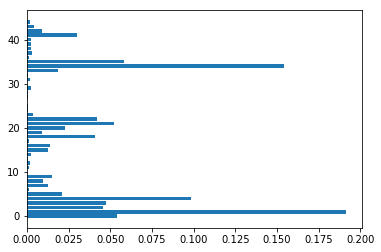

capital_gain                                       0.191145
condensed_marital_Married                          0.154175
relationship_ Husband                              0.098429
condensed_marital_Never                            0.058171
age                                                0.054350
condensed_education_Masters/Professional School    0.052422
hours_per_week                                     0.047491
capital_loss                                       0.045432
condensed_education_No High School Diploma         0.042165
condensed_education_Bachelors                      0.040767
Name: 0, dtype: float64

In [106]:
import matplotlib.pyplot as plt

print (RF7)

plt.barh(range(len(RF7.feature_importances_)), RF7.feature_importances_)
plt.show()

income_ranforest_featureval = pd.DataFrame(RF7.feature_importances_,index=pd.get_dummies(df.drop(ib_drop,1)).columns)

#top 10 feature importances
income_ranforest_featureval[0].sort_values(ascending=False)[:10]

The above bar chart shows feature importance related to the RF7 model. The most important features are capital_gain and codensed_marital_Married.

### Naive Bayes - Income Binary

In [218]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
# Create an object that holds the NB

GNB = GaussianNB()

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num = 0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_income,y_income): 
    X_train = x_income[train_indices]  #train indices for X
    y_train = y_income[train_indices]  #train indices for y
    
    X_test = x_income[test_indices]    #test indices for X
    y_test = y_income[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    GNB.fit(X_train,y_train)  # train object
    y_hat = GNB.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    if (iter_num % 4) == 0:
        accuracy_GNB = accuracy_score(y_test,y_hat)
        print("----Iteration",iter_num," ----")          # print out each numbered interation 
        print('GNB accuracy =', accuracy_GNB)

        # Metric report 
        metrics_GNB = classification_report(y_test,y_hat)
        print('GNB metric report')
        print(metrics_GNB)
        
    iter_num+=1

----Iteration 0  ----
GNB accuracy = 0.768655952503
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.95      0.74      0.83      7431
       >50K       0.51      0.86      0.64      2338

avg / total       0.84      0.77      0.78      9769

----Iteration 4  ----
GNB accuracy = 0.77111270345
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.95      0.74      0.83      7431
       >50K       0.51      0.87      0.64      2338

avg / total       0.84      0.77      0.79      9769

----Iteration 8  ----
GNB accuracy = 0.760773876548
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.95      0.73      0.82      7431
       >50K       0.50      0.87      0.63      2338

avg / total       0.84      0.76      0.78      9769



([<matplotlib.patches.Wedge at 0x115e487f0>,
  <matplotlib.text.Text at 0x115e4ebe0>])

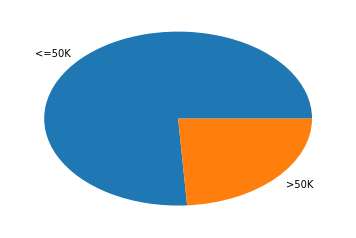

In [225]:
plt.pie(GNB.class_prior_,labels=["<=50K",">50K"])

In [112]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
# Create an object that holds the NB

GNB = BernoulliNB()

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=1
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_income,y_income): 
    X_train = x_income[train_indices]  #train indices for X
    y_train = y_income[train_indices]  #train indices for y
    
    X_test = x_income[test_indices]    #test indices for X
    y_test = y_income[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    GNB.fit(X_train,y_train)  # train object
    y_hat = GNB.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    if (iter_num % 4) == 0:
        accuracy_GNB = accuracy_score(y_test,y_hat)
        print("----Iteration",iter_num," ----")          # print out each numbered interation 
        print('GNB accuracy =', accuracy_GNB)

        # Metric report 
        metrics_GNB = classification_report(y_test,y_hat)
        print('GNB metric report')
        print(metrics_GNB)
        
    iter_num+=1

----Iteration 4  ----
GNB accuracy = 0.762514075136
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.92      0.75      0.83      7431
       >50K       0.50      0.79      0.61      2338

avg / total       0.82      0.76      0.78      9769

----Iteration 8  ----
GNB accuracy = 0.762411710513
GNB metric report
             precision    recall  f1-score   support

      <=50K       0.92      0.76      0.83      7431
       >50K       0.50      0.78      0.61      2338

avg / total       0.82      0.76      0.78      9769



## Models for Age Groups

### Logistic Regression - Age Groups
Below we explored the usefulness of pairing feature selection with logistic regression when predicting age groups. We found that allowing logistic regression to access all features provided the highest accuracy. See below:


In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

model = LogisticRegression(penalty='l2', C=1.0)
rfe = RFE(model, 10)

iter_num=0
acc_scores = []
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  # train indices for X
    y_train = y_ages[train_indices]  # train indices for y
    
    X_test = x_ages[test_indices]    # test indices for X
    y_test = y_ages[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe.fit(X_train,y_train)  # train object
    y_hat_rfe = rfe.predict(X_test) # get test set precitions
    acc_scores.append(accuracy_score(y_test,y_hat_rfe))
    # accuracy and confusion matrix for this iterations of training/testing
    if (iter_num % 4) == 0:
        acc_rfe1 = accuracy_score(y_test,y_hat_rfe)
        conf_rfe1 = confusion_matrix(y_test,y_hat_rfe)
        print("====Iteration",iter_num," ====")
        print("accuracy", acc_rfe1 )
        print("confusion matrix\n",conf_rfe1)
    if iter_num == 5:
        break
    iter_num+=1



====Iteration 0  ====
accuracy 0.574777356945
confusion matrix
 [[   0  117    0    2    0]
 [   0 2809 1191   75    8]
 [   0  787 2485  144   16]
 [   0  238 1214  209   57]
 [   0   57  170   78  112]]
====Iteration 0  ====
accuracy 0.57713174327
confusion matrix
 [[   0  119    0    0    0]
 [   2 2697 1284   91    9]
 [   0  624 2615  168   25]
 [   0  221 1249  204   44]
 [   0   50  167   78  122]]
====Iteration 0  ====
accuracy 0.57273006449
confusion matrix
 [[   0  118    1    0    0]
 [   0 2603 1377   95    8]
 [   0  617 2682  121   12]
 [   0  162 1315  204   37]
 [   0   35  197   79  106]]
====Iteration 0  ====
accuracy 0.57088750128
confusion matrix
 [[   0  119    0    0    0]
 [   0 2690 1296   88    9]
 [   0  691 2546  165   30]
 [   0  203 1250  219   46]
 [   0   50  159   86  122]]
====Iteration 0  ====
accuracy 0.575289180059
confusion matrix
 [[   0  119    0    0    0]
 [   0 2802 1188   88    5]
 [   0  773 2460  175   24]
 [   0  225 1210  224   59]
 [   0 

In [118]:
# Print out the mean 
mean_rfe = np.mean(acc_scores)
print("The mean accuracy for this model is ", mean_rfe)

The mean accuracy for this model is  0.571491452554


In [119]:
#this model trains on all features
lr_clf = LogisticRegression(penalty='l2', C=1.0) # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  # train indices for X
    y_train = y_ages[train_indices]  # train indices for y
    
    X_test = x_ages[test_indices]    # test indices for X
    y_test = y_ages[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    if (iter_num % 4) == 0:
        acc = accuracy_score(y_test,y_hat)
        conf = confusion_matrix(y_test,y_hat)
        print("====Iteration",iter_num," ====")
        print("accuracy", acc )
        print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.580305046576
confusion matrix
 [[   4  113    0    1    1]
 [   4 2841 1155   77    6]
 [   1  774 2482  157   18]
 [   0  238 1191  223   66]
 [   0   76  145   77  119]]
====Iteration 4  ====
accuracy 0.583785443751
confusion matrix
 [[   3  116    0    0    0]
 [   3 2862 1133   76    9]
 [   0  801 2447  158   26]
 [   0  248 1160  247   63]
 [   0   61  124   88  144]]
====Iteration 8  ====
accuracy 0.581226328181
confusion matrix
 [[   8  111    0    0    0]
 [   6 2846 1189   38    4]
 [   1  796 2511  100   24]
 [   0  237 1237  185   59]
 [   0   66  149   74  128]]


In [130]:
np.mean([0.581226328181,0.583785443751,0.580305046576])

0.58177227283599997

In [120]:
model2 = LogisticRegression(penalty='l2', C=0.5)
rfe2 = RFE(model2, 10)
fit2 = rfe.fit(x_ages, y_ages)

In [125]:
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  # train indices for X
    y_train = y_ages[train_indices]  # train indices for y
    
    X_test = x_ages[test_indices]    # test indices for X
    y_test = y_ages[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe2.fit(X_train,y_train)  # train object
    y_hat_rfe2 = rfe2.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    if iter_num == 4 or iter_num == 8:
        acc_rfe2 = accuracy_score(y_test,y_hat_rfe2)
        conf_rfe2 = confusion_matrix(y_test,y_hat_rfe2)
        print("====Iteration",iter_num," ====")
        print("accuracy", acc_rfe2 )
        print("confusion matrix\n",conf_rfe2)
    iter_num+=1


====Iteration 4  ====
accuracy 0.578462483366
confusion matrix
 [[   0  119    0    0    0]
 [   0 2765 1229   84    5]
 [   0  697 2539  172   24]
 [   0  204 1243  214   57]
 [   0   54  156   74  133]]
====Iteration 8  ====
accuracy 0.575596273928
confusion matrix
 [[   0  119    0    0    0]
 [   0 2737 1275   64    7]
 [   0  732 2538  140   22]
 [   0  187 1252  229   50]
 [   0   67  169   62  119]]


In [127]:
model3 = LogisticRegression(penalty='l2', C=1.0)
rfe3 = RFE(model3, 20)
fit3 = rfe.fit(x_ages, y_ages)

In [128]:
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  # train indices for X
    y_train = y_ages[train_indices]  # train indices for y
    
    X_test = x_ages[test_indices]    # test indices for X
    y_test = y_ages[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe3.fit(X_train,y_train)  # train object
    y_hat_rfe3 = rfe3.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc_rfe3 = accuracy_score(y_test,y_hat_rfe3)
    conf_rfe3 = confusion_matrix(y_test,y_hat_rfe3)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc_rfe3 )
    print("confusion matrix\n",conf_rfe3)
    iter_num+=1


====Iteration 0  ====
accuracy 0.578769577234
confusion matrix
 [[   2  115    1    1    0]
 [   3 2839 1206   29    6]
 [   0  776 2526  114   16]
 [   0  229 1251  174   64]
 [   0   74  151   79  113]]
====Iteration 1  ====
accuracy 0.581533422049
confusion matrix
 [[   3  116    0    0    0]
 [   6 2823 1176   70    8]
 [   0  747 2508  153   24]
 [   0  243 1198  217   60]
 [   0   61  146   80  130]]
====Iteration 2  ====
accuracy 0.578769577234
confusion matrix
 [[   5  114    0    0    0]
 [   8 2807 1217   42    9]
 [   0  800 2553   69   10]
 [   0  274 1226  158   60]
 [   0   66  145   75  131]]
====Iteration 3  ====
accuracy 0.572218241376
confusion matrix
 [[   2  117    0    0    0]
 [   1 2794 1211   69    8]
 [   0  784 2481  148   19]
 [   0  239 1217  196   66]
 [   0   62  135  103  117]]
====Iteration 4  ====
accuracy 0.583375985259
confusion matrix
 [[   4  115    0    0    0]
 [   1 2855 1147   72    8]
 [   0  790 2472  147   23]
 [   0  248 1177  224   69]
 [  

Our highest logistic regression model scored 58.1% accuracy, which is substantially lower than that of our income_binary models. This is partially due to the fact that we are attempting to distinguish between four categories instead of two. Our highest logistic regression model used all features in our data set as predictors. However, we noticed substantial improvements with random forest.

### Random Forest - Age Groups

In [136]:
from sklearn.ensemble import RandomForestClassifier

# criterion : 'gini' > 'entropy'
# max_features : 0 -> 42 (default is fine)
# bootstrap : keep True
# max_depth : not material

RFC = RandomForestClassifier()

iteration = 1
scores = []
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  # train indices for X
    y_train = y_ages[train_indices]  # train indices for y
    
    X_test = x_ages[test_indices]    # test indices for X
    y_test = y_ages[test_indices]    # test indices for y
    
    # train the reusable RFC classifier on the training data
    RFC.fit(X_train,y_train)  # train object
    y_hat = RFC.predict(X_test) # get test set precitions
    scores.append(accuracy_score(y_hat,y_test))
    if (iteration%4)==0:
        print(accuracy_score(y_hat,y_test))
    iteration += 1
                  
print('Mean Accuracy : %s' % str(np.mean(scores)))

0.545296345583
0.542634865391
Mean Accuracy : 0.547190091105


In [186]:
# Create an object that holds the second RF model with parameter adjustments

RF2= RandomForestClassifier(max_depth=10, random_state=111)

# Now we want to iterate through and grab the prediction, just like we did in the RF above
# Now we want to iterate through and grab the prediction, just like we did in the KNN above
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  # train indices for X
    y_train = y_ages[train_indices]  # train indices for y
    
    X_test = x_ages[test_indices]    # test indices for X
    y_test = y_ages[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RF2.fit(X_train,y_train)  # train object
    y_hat = RF2.predict(X_test) # get test set precitions
    
    if (iter_num % 4) == 0:
        # Accuracy for the iterations of training/testing
        accuracy_RF2 = accuracy_score(y_test,y_hat)   # obtain accuracies for each iteration 
        print("----Iteration",iter_num," ----")          # print out each numbered interation 
        print('RF2 accuracy =', accuracy_RF2)

        # Metric report 
        metrics_RF2 = classification_report(y_test,y_hat)
        print('RF2 metric report')
        print(metrics_RF2)
    iter_num+=1

----Iteration 0  ----
RF2 accuracy = 0.586958747057
RF2 metric report
             precision    recall  f1-score   support

                  0.64      0.39      0.49       119
      17-34       0.76      0.65      0.70      4083
      35-49       0.49      0.79      0.60      3432
      50-64       0.48      0.11      0.18      1718
        65+       0.57      0.26      0.36       417

avg / total       0.60      0.59      0.56      9769

----Iteration 4  ----
RF2 accuracy = 0.587777664039
RF2 metric report
             precision    recall  f1-score   support

                  0.82      0.30      0.44       119
      17-34       0.74      0.67      0.70      4083
      35-49       0.49      0.77      0.60      3432
      50-64       0.45      0.12      0.19      1718
        65+       0.56      0.34      0.42       417

avg / total       0.60      0.59      0.56      9769

----Iteration 8  ----
RF2 accuracy = 0.582045245163
RF2 metric report
             precision    recall  f1-score

Below we use the same hyperparameters as we did in the highest accuracy model for income_binary.

In [139]:
# Create an object that holds the third RF model with parameter adjustments
# The warm_start parameter reuses the solution of the previous model called and adds more estimators

RF7 = RandomForestClassifier(max_depth=10, random_state=111, n_estimators=150, warm_start=True)

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
scores = []
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  #train indices for X
    y_train = y_ages[train_indices]  #train indices for y
    
    X_test = x_ages[test_indices]    #test indices for X
    y_test = y_ages[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF7.fit(X_train,y_train)  # train object
    y_hat = RF7.predict(X_test) #get the test set predictions 
    scores.append(accuracy_score(y_test,y_hat))
    if (iter_num % 4) == 0:
        # Accuracy for the iterations of training/testing
        accuracy_RF7= accuracy_score(y_test,y_hat)
        print("----Iteration",iter_num," ----")          # print out each numbered interation 
        print('RF7 accuracy =', accuracy_RF7)

        # Metric report 
        metrics_RF7 = classification_report(y_test,y_hat)
        print('RF7 metric report')
        print(metrics_RF7)
    iter_num+=1
    
print('Mean Accuracy : %s' % str(np.mean(scores)))

----Iteration 0  ----
RF7 accuracy = 0.585628006961
RF7 metric report
             precision    recall  f1-score   support

                  0.67      0.02      0.03       119
      17-34       0.74      0.66      0.70      4083
      35-49       0.49      0.79      0.60      3432
      50-64       0.47      0.11      0.18      1718
        65+       0.62      0.28      0.39       417

avg / total       0.60      0.59      0.55      9769

----Iteration 4  ----
RF7 accuracy = 0.605998566895
RF7 metric report
             precision    recall  f1-score   support

                  1.00      0.03      0.07       119
      17-34       0.75      0.68      0.71      4083
      35-49       0.51      0.80      0.62      3432
      50-64       0.57      0.15      0.23      1718
        65+       0.72      0.39      0.50       417

avg / total       0.63      0.61      0.58      9769

----Iteration 8  ----
RF7 accuracy = 0.600163783396
RF7 metric report
             precision    recall  f1-score

In [187]:
# Create an object that holds the third RF model with parameter adjustments
# The warm_start parameter reuses the solution of the previous model called and adds more estimators

RF9 = RandomForestClassifier(max_depth=20, random_state=111, n_estimators=225, warm_start=True)

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
scores = []
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  #train indices for X
    y_train = y_ages[train_indices]  #train indices for y
    
    X_test = x_ages[test_indices]    #test indices for X
    y_test = y_ages[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    RF9.fit(X_train,y_train)  # train object
    y_hat = RF9.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_RF9= accuracy_score(y_test,y_hat)
    print("----Iteration",iter_num," ----")          # print out each numbered interation 
    print('RF9 accuracy =', accuracy_RF9)

    # Metric report 
    metrics_RF9 = classification_report(y_test,y_hat)
    print('RF9 metric report')
    print(metrics_RF9)
    scores.append(accuracy_score(y_test,y_hat))
    iter_num+=1
    
print(np.mean(scores))

----Iteration 0  ----
RF9 accuracy = 0.574879721568
RF9 metric report
             precision    recall  f1-score   support

                  0.58      0.55      0.56       119
      17-34       0.72      0.66      0.69      4083
      35-49       0.50      0.70      0.58      3432
      50-64       0.39      0.19      0.25      1718
        65+       0.53      0.35      0.42       417

avg / total       0.57      0.57      0.56      9769

----Iteration 1  ----
RF9 accuracy = 0.686457160405
RF9 metric report
             precision    recall  f1-score   support

                  0.66      0.56      0.61       119
      17-34       0.79      0.73      0.76      4083
      35-49       0.59      0.81      0.68      3432
      50-64       0.71      0.37      0.49      1718
        65+       0.85      0.63      0.72       417

avg / total       0.71      0.69      0.68      9769

----Iteration 2  ----
RF9 accuracy = 0.68369331559
RF9 metric report
             precision    recall  f1-score 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=225, n_jobs=1,
            oob_score=False, random_state=111, verbose=0, warm_start=True)


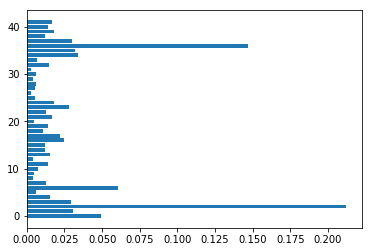

condensed_marital_Never                       0.248310
relationship_ Own-child                       0.120488
hours_per_week                                0.072766
condensed_marital_Divorced/Separated          0.063265
condensed_marital_Married                     0.057090
relationship_ Husband                         0.056324
condensed_marital_Widowed                     0.053892
income_binary_ >50K                           0.042631
income_binary_ <=50K                          0.040698
condensed_education_No High School Diploma    0.031562
Name: 0, dtype: float64

In [188]:
import matplotlib.pyplot as plt

print (RF9)

plt.barh(range(len(RF9.feature_importances_)), RF9.feature_importances_)
plt.show()

income_ranforest_featureval = pd.DataFrame(RF7.feature_importances_,index=pd.get_dummies(df.drop(ag_drop,1)).columns)

#top 10 feature importances
income_ranforest_featureval[0].sort_values(ascending=False)[:10]

In [165]:
accr_ry = []
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  #train indices for X
    y_train = y_ages[train_indices]  #train indices for y
    
    X_test = x_ages[test_indices]    #test indices for X
    y_test = y_ages[test_indices]    #test indices for y

    y_hat = ab.predict(X_test)
    accuracy = accuracy_score(y_hat,y_test)
    accr_ry.append(accuracy)

In [166]:
print(accr_ry)

[0.4967755143822295, 0.49564950353157949, 0.49698024362780224, 0.49083836626062033, 0.49513768041764766, 0.4850035827617975, 0.49196437711127033, 0.48991708465554307, 0.49186201248848399, 0.48981472003275667]


In [ ]:
import matplotlib.pyplot as plt

print (RF9)

plt.barh(range(len(RF7.feature_importances_)), RF9.feature_importances_)
plt.show()

income_ranforest_featureval = pd.DataFrame(RF9.feature_importances_,index=pd.get_dummies(df.drop(ag_drop,1)).columns)

#top 10 feature importances
income_ranforest_featureval[0].sort_values(ascending=False)[:10]

### Adaboost Classification for Age Groups

In [163]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier()

iteration = 1
scores = []
for train_indices, test_indices in sss.split(x_ages,y_ages): 
    X_train = x_ages[train_indices]  # train indices for X          
    y_train = y_ages[train_indices]  # train indices for y         
    
    X_test = x_ages[test_indices]    # test indices for X
    y_test = y_ages[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    ab.fit(X_train,y_train)  # train object
    y_hat = ab.predict(X_test) # get test set precitions
    
    scores.append(accuracy_score(y_hat,y_test))
    #lets print the 4th and the 8th iter to keep things viewable
    if len(scores)%4 == 0:
        print(classification_report(y_hat,y_test))
    

print("Mean Accuracy : ", np.mean(scores))

             precision    recall  f1-score   support

                  0.89      0.40      0.55       265
      17-34       0.64      0.71      0.67      3682
      35-49       0.70      0.49      0.58      4902
      50-64       0.15      0.39      0.22       672
        65+       0.31      0.52      0.39       248

avg / total       0.63      0.56      0.58      9769

             precision    recall  f1-score   support

                  0.90      0.39      0.54       274
      17-34       0.62      0.71      0.66      3552
      35-49       0.62      0.50      0.55      4324
      50-64       0.29      0.36      0.32      1415
        65+       0.27      0.55      0.36       204

avg / total       0.57      0.55      0.55      9769

Mean Accuracy :  0.543597092845


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


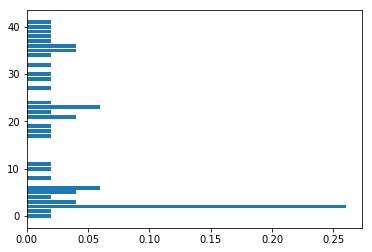

hours_per_week                                0.26
relationship_ Own-child                       0.06
condensed_education_No High School Diploma    0.06
relationship_ Husband                         0.04
condensed_marital_Never                       0.04
condensed_marital_Married                     0.04
relationship_ Other-relative                  0.04
condensed_education_High School Graduate      0.04
capital_loss                                  0.02
relationship_ Not-in-family                   0.02
Name: 0, dtype: float64

In [217]:
ab.feature_importances_

print (ab)

plt.barh(range(len(ab.feature_importances_)), ab.feature_importances_)
plt.show()

income_ranforest_featureval = pd.DataFrame(ab.feature_importances_,index=pd.get_dummies(df.drop(ag_drop,1)).columns)

#top 10 feature importances
income_ranforest_featureval[0].sort_values(ascending=False)[:10]

## Confidence Interval Calculation 

### Income Binary Intervals

In [148]:
# Calculating the Error Rates of the three models 

# KNN Model
KNN_Accs = [83.53, 83.93, 83.31, 83.07, 83.30, 83.56, 83.78, 83.34, 83.75, 83.88]

iter_num=0
for x in KNN_Accs:
    KNN_ER = 100-x
    print("----Iteration",iter_num," ----") 
    print('KNN Error Rate =', KNN_ER)
    iter_num+=1

# RF Model 
RF_Accs = [85.63, 86.42, 86.09, 85.38, 86.03, 86.27, 86.23, 85.58, 86.04, 86.17]

iter_num=0
for x in RF_Accs:
    RF_ER = 100-x
    print("----Iteration",iter_num," ----") 
    print('RF Error Rate =', RF_ER)
    iter_num+=1
    
# BNB Model 
BNB_Accs = [74.40, 75.01, 74.23, 74.84, 75.10, 75.13, 74.83, 74.75, 74.05, 74.84]

iter_num=0
for x in BNB_Accs:
    BNB_ER = 100-x
    print("----Iteration",iter_num," ----") 
    print('BNB Error Rate =', BNB_ER)
    iter_num+=1

----Iteration 0  ----
KNN Error Rate = 16.47
----Iteration 1  ----
KNN Error Rate = 16.069999999999993
----Iteration 2  ----
KNN Error Rate = 16.689999999999998
----Iteration 3  ----
KNN Error Rate = 16.930000000000007
----Iteration 4  ----
KNN Error Rate = 16.700000000000003
----Iteration 5  ----
KNN Error Rate = 16.439999999999998
----Iteration 6  ----
KNN Error Rate = 16.22
----Iteration 7  ----
KNN Error Rate = 16.659999999999997
----Iteration 8  ----
KNN Error Rate = 16.25
----Iteration 9  ----
KNN Error Rate = 16.120000000000005
----Iteration 0  ----
RF Error Rate = 14.370000000000005
----Iteration 1  ----
RF Error Rate = 13.579999999999998
----Iteration 2  ----
RF Error Rate = 13.909999999999997
----Iteration 3  ----
RF Error Rate = 14.620000000000005
----Iteration 4  ----
RF Error Rate = 13.969999999999999
----Iteration 5  ----
RF Error Rate = 13.730000000000004
----Iteration 6  ----
RF Error Rate = 13.769999999999996
----Iteration 7  ----
RF Error Rate = 14.420000000000002
---

In [149]:
# Calculate the difference in the error rate bewteen each model comparsion
KNN_ER = np.array([16.47, 16.07, 16.69, 16.93, 16.7, 16.44, 16.22, 16.66, 16.25, 16.12])
RF_ER = np.array([14.37, 13.58, 13.91, 14.62, 13.97, 13.73, 13.77, 14.42, 13.96, 13.83])
BNB_ER = np.array([25.6, 24.99, 25.77, 25.16, 24.9, 24.87, 25.17, 25.25, 25.95, 25.16])

# KNN to RF 
Diff1 = KNN_ER - RF_ER
print(Diff1)

# KNN to BNB
Diff2 = KNN_ER - BNB_ER
print(Diff2)

# RF to BNB
Diff3 = RF_ER - BNB_ER
print(Diff3)

[ 2.1   2.49  2.78  2.31  2.73  2.71  2.45  2.24  2.29  2.29]
[-9.13 -8.92 -9.08 -8.23 -8.2  -8.43 -8.95 -8.59 -9.7  -9.04]
[-11.23 -11.41 -11.86 -10.54 -10.93 -11.14 -11.4  -10.83 -11.99 -11.33]


In [150]:
# Calculate the mean of the differance in Error Rates for each model comparison

# KNN to RF 
mean1 = np.mean(Diff1)
print(mean1)

# KNN to BNB
mean2 = np.mean(Diff2)
print(mean2)

# RF to BNB
mean3 = np.mean(Diff3)
print(mean3)

2.439
-8.827
-11.266


In [151]:
# Calculate the Variance of the differance in Error Rates for each model comparison
K = 10 

# KNN to RF 
for x in Diff1:
    y = x-mean1
    #print(y)

sumy = np.sum(y)
# print(sumy)

V = (1/K-1)*(sumy)
print('Variance for KNN & RF =', V)

# KNN to BNB
for x in Diff2:
    y2 = x-mean2
    #print(y)

sumy2 = np.sum(y2)
# print(sumy)

V2 = (1/K-1)*(sumy2)
print('Variance for KNN & BNB =', V2)

# RF to BNB
for x in Diff3:
    y3 = x-mean3
    #print(y)

sumy3 = np.sum(y3)
# print(sumy)

V3 = (1/K-1)*(sumy3)
print('Variance for RF & BNB =', V3)

Variance for KNN & RF = 0.1341
Variance for KNN & BNB = 0.1917
Variance for RF & BNB = 0.0576


In [153]:
import math
# Calculate the Confidence Intervals for each comparison
K = 10
t_stat = 1.812

# KNN to RF
l = 1/math.sqrt(K)*t_stat*V

CI_plus = mean1 + l
CI_minus = mean1 - l
print('Confidence Interval for KNN and RF is', CI_minus, CI_plus)

Confidence Interval for KNN and RF is 2.36216006812 2.51583993188


In [155]:
# KNN to BNB
l = 1/math.sqrt(K)*t_stat*V2

CI_plus2 = mean2 + l
CI_minus2 = mean2 - l
print('Confidence Interval for KNN and BNB is', CI_minus2, CI_plus2)

# RF to BNB
l = 1/math.sqrt(K)*t_stat*V3

CI_plus3 = mean3 + l
CI_minus3 = mean3 - l
print('Confidence Interval for RF and BNB is', CI_minus3, CI_plus3)

Confidence Interval for KNN and BNB is -8.93684500329 -8.71715499671
Confidence Interval for RF and BNB is -11.2990050714 -11.2329949286


### Age Groups Intervals

In [170]:
# Calculating the Error Rates of the three models 

# KNN Model
Random_Forest = [0.57487972156822598, 0.68645716040536386, 0.68369331559013202, 0.679189272187532,
                 0.6829767632306275, 0.68195311700276384, 0.67642542737230016, 0.67263793632920466,
                 0.68236257549390933, 0.67949636605589103]

rf_array = []
iter_num=0
for x in Random_Forest:
    KNN_ER = 1-x
    print("----Iteration",iter_num," ----") 
    print('RF Error Rate =', KNN_ER)
    iter_num+=1
    rf_array.append(KNN_ER)
    

# RF Model 
logistic = [0.58132869280376698, 0.58276179752277613, 0.58327362063670796, 0.57621046166444878,
           0.58480908997850345,0.57887194185689428,
           0.5716040536390623, 0.57569863855051695, 0.58214760978605795, 0.57846248336574879]

logarray = []
iter_num=0
for x in logistic:
    RF_ER = 1-x
    print("----Iteration",iter_num," ----") 
    print('Logistic Error Rate =', RF_ER)
    iter_num+=1
    logarray.append(RF_ER)
    
# BNB Model 
BNB_Accs = [0.4967755143822295, 0.49564950353157949, 0.49698024362780224, 0.49083836626062033,
            0.49513768041764766, 0.4850035827617975,
            0.49196437711127033, 0.48991708465554307, 0.49186201248848399, 0.48981472003275667]

ada_array = []
iter_num=0
for x in BNB_Accs:
    BNB_ER = 1-x
    print("----Iteration",iter_num," ----") 
    print('AdaBoost Error Rate =', BNB_ER)
    iter_num+=1
    ada_array.append(BNB_ER)

----Iteration 0  ----
RF Error Rate = 0.425120278431774
----Iteration 1  ----
RF Error Rate = 0.31354283959463614
----Iteration 2  ----
RF Error Rate = 0.316306684409868
----Iteration 3  ----
RF Error Rate = 0.320810727812468
----Iteration 4  ----
RF Error Rate = 0.3170232367693725
----Iteration 5  ----
RF Error Rate = 0.31804688299723616
----Iteration 6  ----
RF Error Rate = 0.32357457262769984
----Iteration 7  ----
RF Error Rate = 0.32736206367079534
----Iteration 8  ----
RF Error Rate = 0.31763742450609067
----Iteration 9  ----
RF Error Rate = 0.32050363394410897
----Iteration 0  ----
Logistic Error Rate = 0.418671307196233
----Iteration 1  ----
Logistic Error Rate = 0.4172382024772239
----Iteration 2  ----
Logistic Error Rate = 0.41672637936329204
----Iteration 3  ----
Logistic Error Rate = 0.4237895383355512
----Iteration 4  ----
Logistic Error Rate = 0.41519091002149655
----Iteration 5  ----
Logistic Error Rate = 0.4211280581431057
----Iteration 6  ----
Logistic Error Rate = 0.42

In [172]:
print(ada_array, '\n \n')

print(rf_array, '\n \n')

print(logarray, '\n \n')

[0.5032244856177706, 0.5043504964684205, 0.5030197563721978, 0.5091616337393796, 0.5048623195823523, 0.5149964172382024, 0.5080356228887297, 0.5100829153444569, 0.508137987511516, 0.5101852799672433] 
 

[0.425120278431774, 0.31354283959463614, 0.316306684409868, 0.320810727812468, 0.3170232367693725, 0.31804688299723616, 0.32357457262769984, 0.32736206367079534, 0.31763742450609067, 0.32050363394410897] 
 

[0.418671307196233, 0.4172382024772239, 0.41672637936329204, 0.4237895383355512, 0.41519091002149655, 0.4211280581431057, 0.4283959463609377, 0.42430136144948305, 0.41785239021394205, 0.4215375166342512] 
 



In [173]:
# Calculate the difference in the error rate bewteen each model comparsion
LOGI_ER = np.array([0.418671307196233, 0.4172382024772239, 0.41672637936329204, 0.4237895383355512, 0.41519091002149655, 0.4211280581431057, 0.4283959463609377, 0.42430136144948305, 0.41785239021394205, 0.4215375166342512] )
RF_ER = np.array([0.425120278431774, 0.31354283959463614, 0.316306684409868, 0.320810727812468, 0.3170232367693725, 0.31804688299723616, 0.32357457262769984, 0.32736206367079534, 0.31763742450609067, 0.32050363394410897])
ADA_ER = np.array([0.5032244856177706, 0.5043504964684205, 0.5030197563721978, 0.5091616337393796, 0.5048623195823523, 0.5149964172382024, 0.5080356228887297, 0.5100829153444569, 0.508137987511516, 0.5101852799672433])

# KNN to RF 
Diff1 = LOGI_ER - RF_ER
print(Diff1)

# KNN to BNB
Diff2 = LOGI_ER - ADA_ER
print(Diff2)

# RF to BNB
Diff3 = RF_ER - ADA_ER
print(Diff3)

[-0.00644897  0.10369536  0.10041969  0.10297881  0.09816767  0.10308118
  0.10482137  0.0969393   0.10021497  0.10103388]
[-0.08455318 -0.08711229 -0.08629338 -0.0853721  -0.08967141 -0.09386836
 -0.07963968 -0.08578155 -0.0902856  -0.08864776]
[-0.07810421 -0.19080766 -0.18671307 -0.18835091 -0.18783908 -0.19694953
 -0.18446105 -0.18272085 -0.19050056 -0.18968165]


In [174]:
# Calculate the mean of the differance in Error Rates for each model comparison

# KNN to RF 
mean1 = np.mean(Diff1)
print(mean1)

# KNN to BNB
mean2 = np.mean(Diff2)
print(mean2)

# RF to BNB
mean3 = np.mean(Diff3)
print(mean3)

0.0904903265431
-0.0871225304535
-0.177612856997


In [175]:
# Calculate the Variance of the differance in Error Rates for each model comparison
K = 10 

# KNN to RF 
for x in Diff1:
    y = x-mean1
    #print(y)

sumy = np.sum(y)
# print(sumy)

V = (1/K-1)*(sumy)
print('Variance for LOGI & RF =', V)

# KNN to BNB
for x in Diff2:
    y2 = x-mean2
    #print(y)

sumy2 = np.sum(y2)
# print(sumy)

V2 = (1/K-1)*(sumy2)
print('Variance for LOGI & ADA =', V2)

# RF to BNB
for x in Diff3:
    y3 = x-mean3
    #print(y)

sumy3 = np.sum(y3)
# print(sumy)

V3 = (1/K-1)*(sumy3)
print('Variance for RF & ADA =', V3)

Variance for LOGI & RF = -0.0094892005323
Variance for LOGI & ADA = 0.00137270959157
Variance for RF & ADA = 0.0108619101239


In [176]:
import math
# Calculate the Confidence Intervals for each comparison
K = 10
t_stat = 1.812

# KNN to RF
l = 1/math.sqrt(K)*t_stat*V

CI_plus = mean1 + l
CI_minus = mean1 - l
print('Confidence Interval for LOGI and RF is', CI_minus, CI_plus)

Confidence Interval for KNN and RF is 0.0959276831615 0.0850529699248


In [177]:
# KNN to BNB
l = 1/math.sqrt(K)*t_stat*V2

CI_plus2 = mean2 + l
CI_minus2 = mean2 - l
print('Confidence Interval for LOGI and ADA is', CI_minus2, CI_plus2)

# RF to BNB
l = 1/math.sqrt(K)*t_stat*V3

CI_plus3 = mean3 + l
CI_minus3 = mean3 - l
print('Confidence Interval for RF and ADA is', CI_minus3, CI_plus3)

Confidence Interval for LOGI and ADA is -0.0879090995177 -0.0863359613893
Confidence Interval for RF and ADA is -0.183836782679 -0.171388931314


## Income Binary Modeling - Results, Advantages & Attribute Analysis

### Best Model

Our best model was a random forest named RF7, which used the following hyperparameters:
* max_depth = 10
* n_estimators = 150
* warm_start = True


With an accuracy of 86.0%, this model has the highest out of those we tested. These included random forest, Gaussian naive bayes, Bernoulli naive bayes, K-Nearest Neighbors and K-Nearest Neighbors with PCA.

### Advantages of Each - Confidence Intervals

We are 95% confident that our best K-Nearest Neighbors model is between 8.72% and 8.94% more accurate than our Bernoulli naive bayes model. We are 95% confident that our best random forest model is between 2.36% and 2.52% more accurate than our best K-Nearest Neighbors model. Lastly, we are 95% confident that our best random forest model is between 11.23% and 11.30% more accurate than our Bernoulli naive bayes model. Therefore, our best random forest model is our most accurate model overall. 

All three algorithms had fast training times and reasonably high accuracy. However, random forest is both the fastest and most accurate of the three.

### Attribute Analysis

The attributes selected by our best random forest model were heavily reliant on capital gain and the marital status of an individual. Those who are married will generally have a higher income because it is shared and capital gain is a unique attribute that infrequently has a value greater than 0. When there is a positive capital gain, it indicates an individual making savvy financial decisions, which the model uses to great effect. The third most leveraged feature, *relationship_Husband*, also provides significant value to our model. Because our data was compiled in 1994, we can expect relationship to head of household to have a stronger influence on earning power.

<img src="income_bin.png" alt="Drawing" style="width: 600px;"/>


## Age Groups Modeling - Results, Advantages & Attribute Analysis

### Best Model

Our best model is a random forest that dramatically outperforms other models with 67% accuracy. This is higher than the next best model by 10%.
* max_depth = 20
* n_estimators = 225
* warm_start = True

### Advantages of Each - Confidence Intervals

We are 95% confident that our best logistic regression model is between 8.63% and 8.79% more accurate than our adaboost model. We are 95% confident that our best random forest model is between 8.50% and 9.59% more accurate than our best logistic regression model. Lastly, we are 95% confident that our best random forest model is between 17.14% and 18.38% more accurate than our adaboost model. Therefore, our best random forest model is our most accurate model overall. 

Random forest trumps both logistic regression and adaboost in terms of both accuracy and training time. Generally, logistic regression has the longest training time of the three algorithms. However, adaboost can take longer when a user passes a complex model through the function.  Logistic regression is significantly more accurate than adaboost.

### Attribute Analysis

Our most accurate model for predicting age groups was random forest. The features favored by this model were *condensed_marital_Never* and *relationship_ Own-child*. Because younger people are less likely to have been married, the most highly ranked feature logical. Individuals under 35 are the least likely to have children, which allows our model to narrow the range of likely classes.

<img src="age_grps.png" alt="Drawing" style="width: 600px;"/>

# Deployment 

Our model provides some insights into what types of data are most useful when trying to fill in gaps of information common in census data. This makes our models useful for entities that want to determine how to keep costs low when sampling or for parties that already have data with portions that are incomplete.

Entities that are likely to face these problems would be governmental agencies, economic think tanks and research agencies determining how to structure an economic policy so that it will produce the desired effect. In these circumstances, the model would need to be retrained on the pre-existing data that is most relevant and desirable for the cause. The visualization and attribute exploration done above should be reproduced when using different data to review what attributes are useful. 

Because of changes in data quality over time, our models will not hold for present day data, but our general framework will. Users should consider the techniques we have used, including:

* Bucketing class variables to be more concise,
* Dropping unneccessary variables and
* Stratified sample splits on training and test data.


We would deploy our model as a persitent SciKit learn file that could be easily retrained on new data as it was collected. The original model should be produced from the above code and adjusted to account for changing predictor variables. A command line interface or GUI that allows users to input new data and get an output prediction would be incredibly valuable for these parties. It would allow real-time analysis of variables that are collected by the entity. If this model's use extends to active sales environments, these GUI tools would help sales representatives target perspective clients more efficently.


# Exceptional Work
## Neural Net Classifier with Tensorflow
For exceptional work, our team attempted to implement a neural net classifier for our *income_binary* variable. As shown below, the neural net classifier did not outperform our random forest model chosen above. 

This could be due to a few factors. The first is that the sample size is not large enough to learn strong enough patterns to provide high accuracy. The second is that we were unable to tune our hyperparameters appropriately. While we attempted to change the learning rate and batch size, we were unable to discover a useful pair.


In [193]:
# delete unwanted variables from x and setup to be used in classifier
y_nn = pd.get_dummies(df['income_binary']).values

ib_drop = ['income_binary','workclass','education','education_num',
             'marital_status','occupation','native_country','Unnamed: 0']
x_nn = df.drop(ib_drop,1)
x_nn = pd.get_dummies(x_nn).values

#leaving standard sclaer out of this
#x_income = StandardScaler().fit_transform(x_income)

In [194]:
np.shape(x_nn)

(48842, 45)

In [209]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

def next_batch(num, data):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]

    return np.asarray(data_shuffle)


In [210]:

# Parameters
learning_rate = 0.005
num_steps = 300
batch_size = 1000
display_step = 100

# Network Parameters
n_hidden_1 = 41 # 1st layer number of neurons
n_hidden_2 = 30 # 2nd layer number of neurons
num_input = 45 # MNIST data input (img shape: 28*28)
num_classes = 2 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [211]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [212]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [213]:
# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [214]:
# this is already in memory but lets put this here again to be explicit!
# we will train on the last instance produced by the loop
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=111)

# Create a for loop that grabs the values for each fold for traing and test sets
for train_index, test_index in sss.split(x_nn, y_nn):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_nn_train, X_nn_test = x_nn[train_index], x_nn[test_index]
    y_nn_train, y_nn_test = y_nn[train_index], y_nn[test_index]
    

TRAIN: [14876 22320 41985 ..., 19522 28814 36387] TEST: [29738 44261 34830 ..., 12340 37898 13833]
TRAIN: [29628 28812  9156 ..., 48484 39868 28157] TEST: [32354 31246  7467 ..., 32134 45296 19815]
TRAIN: [46315 27749 35701 ..., 31999 28258 30895] TEST: [ 4677 38297  4912 ..., 40101 42037 47325]
TRAIN: [46672 34976  4341 ..., 15969 27786 26581] TEST: [37091  4457  3749 ..., 36106   552 41663]
TRAIN: [30957 37681  4013 ...,  3715 18167  5620] TEST: [28726 31585 10034 ..., 18672 13453 21320]
TRAIN: [35202 31504   951 ..., 22581  9973 12807] TEST: [41724 16612 44504 ..., 43412 32533 27102]
TRAIN: [37272 33088 26421 ..., 18102 24409 39839] TEST: [  902 19885 28710 ..., 47220 47624  2630]
TRAIN: [ 8007 24612 33169 ..., 23413 33596 39920] TEST: [23701 18082 47214 ..., 48030  8495 46476]
TRAIN: [16291 40068 30544 ..., 36051  3037 43803] TEST: [24803 15997 21867 ..., 19729  8425 38141]
TRAIN: [29930 16988 33292 ..., 39480 20668 44948] TEST: [23889 38609 11707 ..., 34482  6608 28111]


In [215]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = next_batch(batch_size,X_nn_train.tolist()), next_batch(batch_size,y_nn_train.tolist())
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: X_nn_test,
                                      Y: y_nn_test}))

Step 1, Minibatch Loss= 13117.2617, Training Accuracy= 0.323
Step 100, Minibatch Loss= 642.5598, Training Accuracy= 0.728
Step 200, Minibatch Loss= 799.8663, Training Accuracy= 0.398
Step 300, Minibatch Loss= 132.0009, Training Accuracy= 0.651
Optimization Finished!
Testing Accuracy: 0.684922
